<a href="https://colab.research.google.com/github/pragyan7/ML-projects/blob/main/Fake_News_Detection_1_0_(text_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📓 Step 1: Setup & Install Dependencies

In [19]:
# Install required libraries
!pip install -q pyspark mlflow sqlalchemy shap

# Other core libraries
import pandas as pd
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import sqlite3

📓 Step 2: Load Dataset (Text Only)

In [3]:
# Download dataset from Kaggle manually and upload to Colab

fake_df = pd.read_csv("Fake.csv")
real_df = pd.read_csv("True.csv")

print("Fake shape:", fake_df.shape)
print("Real shape:", real_df.shape)


Fake shape: (23481, 4)
Real shape: (21417, 4)


In [4]:
# Add labels
fake_df['label'] = 0
real_df['label'] = 1

# Combine and shuffle
df = pd.concat([fake_df, real_df], axis=0).sample(frac=1).reset_index(drop=True)
df = df[['title', 'text', 'label']]

df.head()

,title,text,label
0,Winnie Mandela 'in high spirits' after minor s...,JOHANNESBURG (Reuters) - South African anti-ap...,1
1,TUCKER CARLSON Embarrasses Colby Professor Who...,From Hanlon s piece in the New Republic:Reject...,0
2,EU executive not assessing impact of Catalan c...,BRUSSELS (Reuters) - The European Union s exec...,1
3,WATCH: ‘The View’ Unanimously Rips Trump A Ne...,The women of The View played the tape of Trump...,0
4,Trump Campaign CEO Didn’t Want His Kids In Sc...,The court records from the divorce of Trump s ...,0


📓 Step 3: PySpark Preprocessing

In [5]:
# Start pyspark session
spark = SparkSession.builder \
    .appName("FakeNewsDetection") \
    .getOrCreate()

# Convert pandas dataframe to Spark DataFrame
spark_df = spark.createDataFrame(df)
spark_df.printSchema()

spark_df.select('text', 'label').show(5, truncate=80)

spark_df = spark_df.dropna()
spark_df = spark_df.filter(length(col('text')) > 100)

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: long (nullable = true)

+--------------------------------------------------------------------------------+-----+
|                                                                            text|label|
+--------------------------------------------------------------------------------+-----+
|JOHANNESBURG (Reuters) - South African anti-apartheid veteran Winnie Madikize...|    1|
|From Hanlon s piece in the New Republic:Rejecting campus speakers is not an a...|    0|
|BRUSSELS (Reuters) - The European Union s executive arm, the European Commiss...|    1|
|The women of The View played the tape of Trump s grotesque remarks about grop...|    0|
|The court records from the divorce of Trump s new campaign CEO have proved to...|    0|
+--------------------------------------------------------------------------------+-----+
only showing top 5 rows



📓 Step 4: TF-IDF + Train-Test Split

In [6]:
# Convert Spark → Pandas for model training
clean_df = spark_df.toPandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['label'], test_size=0.2, random_state=42)

#TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)   # max_df specifies that terms that appear in more than 70% of documents should be ignored
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)                      # apply the 'same' vocabulary and IDF that were learned from the training data to the test data. If we were to call fit_transform() on test data, the vectorizer would learn a 'new' vocabulary and IDF based solely on the test set, which would not be representative of the overall data distribution and could lead to inaccurate results when evaluating the model.

📓 Step 5: Train Model & Evaluate

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(confusion_matrix(y_test, y_pred))

[[4509   36]
 [  47 4179]]


In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4545
           1       0.99      0.99      0.99      4226

    accuracy                           0.99      8771
   macro avg       0.99      0.99      0.99      8771
weighted avg       0.99      0.99      0.99      8771



📓 Step 6: MLflow Tracking

Using the MLflow library to track the details and results of the machine learning experiment.

*   A "run" represents a single execution of your machine learning code.
*   Parameters are typically used to record the configuration or settings of your experiment



In [11]:
mlflow.set_experiment("Fake News Detection")

with mlflow.start_run():
    mlflow.log_param("vectorizer", "TF-IDF")
    mlflow.log_param("model", "RandomForest")

    mlflow.log_metric("accuracy", model.score(X_test_tfidf, y_test))
    # Use 'name' instead of 'artifact_path' which is deprecated
    # Add input_example for better model logging
    mlflow.sklearn.log_model(model, name="model", input_example=X_train_tfidf[:2].toarray())
    mlflow.log_artifact("Fake.csv")
    # mlflow.log_artifact("True.csv")

In [12]:
!mlflow ui

[2025-07-10 06:08:08 +0000] [11797] [INFO] Starting gunicorn 23.0.0
[2025-07-10 06:08:08 +0000] [11797] [INFO] Listening at: http://127.0.0.1:5000 (11797)
[2025-07-10 06:08:08 +0000] [11797] [INFO] Using worker: sync
[2025-07-10 06:08:08 +0000] [11798] [INFO] Booting worker with pid: 11798
[2025-07-10 06:08:08 +0000] [11803] [INFO] Booting worker with pid: 11803
[2025-07-10 06:08:08 +0000] [11806] [INFO] Booting worker with pid: 11806
[2025-07-10 06:08:08 +0000] [11807] [INFO] Booting worker with pid: 11807
[2025-07-10 06:43:56 +0000] [11797] [INFO] Handling signal: int

Aborted!
[2025-07-10 06:43:56 +0000] [11803] [INFO] Worker exiting (pid: 11803)
[2025-07-10 06:43:56 +0000] [11798] [INFO] Worker exiting (pid: 11798)
[2025-07-10 06:43:56 +0000] [11806] [INFO] Worker exiting (pid: 11806)
[2025-07-10 06:43:56 +0000] [11807] [INFO] Worker exiting (pid: 11807)
[2025-07-10 06:43:57 +0000] [11797] [INFO] Shutting down: Master


📓 Step 7: Store Results in SQL (SQLite)

In [13]:
conn = sqlite3.connect("predictions.db")
results_df = pd.DataFrame({
    'text': X_test,
    'label': y_test,
    'predicted': y_pred
})

results_df.to_sql("predictions", conn, if_exists='replace', index=False)

8771

In [14]:
results_df

,text,label,predicted
36565,NAIROBI (Reuters) - The U.S. embassy in Eritre...,1,1
26992,If you re one of the people who saw Sarah Pali...,0,0
29194,The first shot against PC tyranny in Virginia ...,0,0
7963,MEXICO CITY (Reuters) - Pro-trade Republicans ...,1,1
27717,So many acts of violence and vandalism have be...,0,0
...,...,...,...
23656,"BEDMINSTER, N.J. (Reuters) - President-elect D...",1,1
42658,KUALA LUMPUR (Reuters) - Malaysia is negotiati...,1,1
40649,There s often much debate about the use of the...,0,0
25632,WASHINGTON (Reuters) - U.S. House Democratic l...,1,1


📓 Step 8: Confusion Matrix (Heatmap)

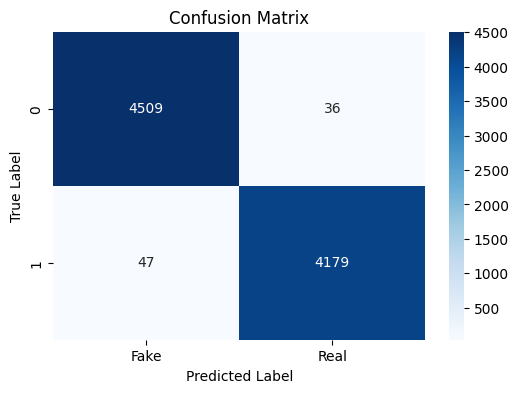

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ['Fake', 'Real']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

📓 Step 9: ROC Curve

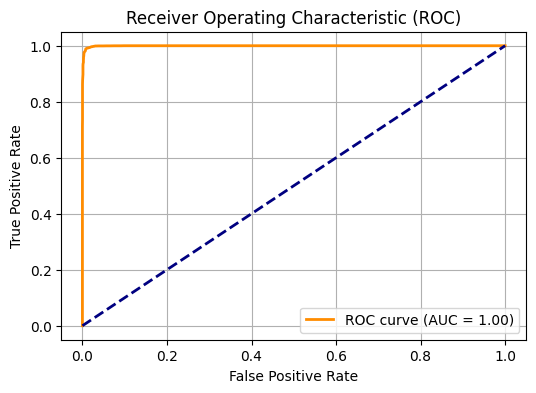

In [18]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test_tfidf)[:, 1]

# ROC Computation
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

SHAP on TF-IDF + RandomForest

This code is designed to visualize SHAP (SHapley Additive exPlanations) values for a machine learning model, specifically for one test sample's prediction for the positive class (class 1). It's typically used in text classification models that use TF-IDF features.

In [27]:
import shap
import numpy as np


background_data = X_train_tfidf[:100].toarray()
explainer = shap.TreeExplainer(model, background_data)

# Select a single test sample to explain and convert it to a dense array
sample_idx = 5
test_sample_dense = X_test_tfidf[sample_idx].toarray()

# Calculate SHAP values for the selected test sample
shap_values = explainer(test_sample_dense)


Displaying Waterfall Plot for Positive Class:


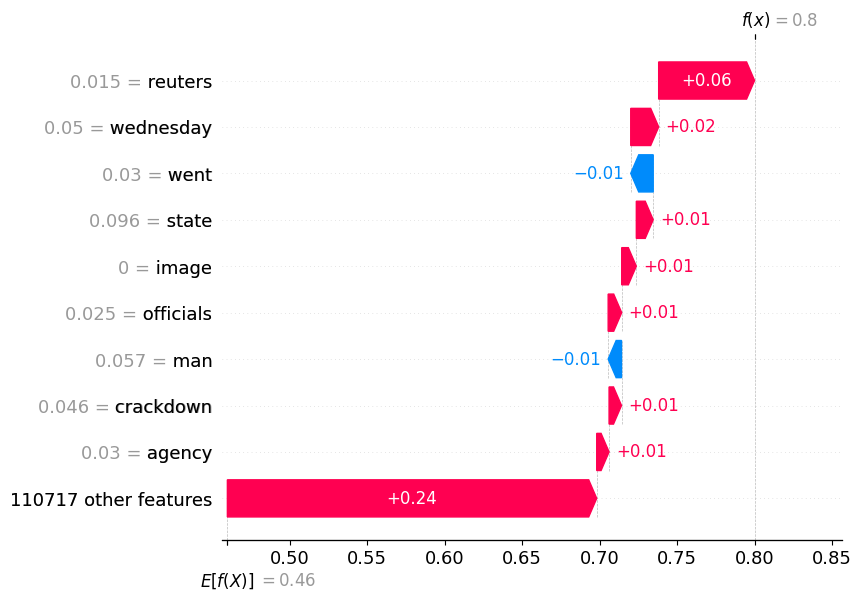

In [39]:
import shap
import numpy as np

# To use shap.plots.text, we need to associate the SHAP values with the original text
# and the corresponding feature names (which are the words/terms in the TF-IDF vocabulary).

original_text_sample = X_test.iloc[sample_idx]

feature_names = tfidf.get_feature_names_out()

# Ensure shap_values is a single sample explanation if it's not already
if isinstance(shap_values, list):
    shap_values_single = shap_values[0]
else:
    shap_values_single = shap_values

# # --- Inspection Code ---
# print("Type of shap_values_single:", type(shap_values_single))
# if hasattr(shap_values_single, 'shape'):
#     print("Shape of shap_values_single:", shap_values_single.shape)
# if hasattr(shap_values_single, 'values'):
#     print("Type of shap_values_single.values:", type(shap_values_single.values))
#     print("Shape of shap_values_single.values:", shap_values_single.values.shape)
# if hasattr(shap_values_single, 'base_values'):
#     print("Type of shap_values_single.base_values:", type(shap_values_single.base_values))
#     print("Shape of shap_values_single.base_values:", shap_values_single.base_values.shape)
# # --- End Inspection Code ---


# The waterfall plot is a good alternative to understand the contribution of each feature.

# Select the SHAP values and base value for the positive class (class 1)
# Access the values for the first sample and the positive class output
shap_values_positive_class_values = shap_values_single.values[0, :, 1]
# Access the base value for the first sample and the positive class output
base_value_positive_class = shap_values_single.base_values[0, 1]
# Get the data (feature values) for the first sample
sample_data = shap_values_single.data[0, :]


# Create a new Explanation object for the positive class
shap_explanation_positive_class = shap.Explanation(
    values=shap_values_positive_class_values,
    base_values=base_value_positive_class,
    data=sample_data,
    feature_names=feature_names
)


# Display the waterfall plot for the positive class explanation
print("Displaying Waterfall Plot for Positive Class:")
shap.plots.waterfall(shap_explanation_positive_class)

In [40]:
!pip install -q gradio

In [42]:
# Define prediction function
def classify_news(text):
    if not text.strip():
        return "Please enter a news article", 0.0

    # Transform input using the same TF-IDF vectorizer
    text_tfidf = tfidf.transform([text])

    # Predict
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0][prediction]

    # Convert label to human-readable
    label = "Real News" if prediction == 1 else "Fake News"
    return label, float(f"{probability:.2f}")


In [43]:
import gradio as gr

# Gradio interface
demo = gr.Interface(
    fn=classify_news,
    inputs=gr.Textbox(lines=10, placeholder="Paste a news article here...", label="News Article"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Number(label="Confidence Score")
    ],
    title="📰 Fake News Detector",
    description="Enter a news article to classify it as FAKE or REAL using a machine learning model.",
    allow_flagging="never"
)

# Launch the app
demo.launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cff52ac92c4b68fa82.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
